# FinOpt — Simulation & Optimization Demo

This notebook showcases the **current MVP** of FinOpt:

- Income modeling → monthly contributions
- Three-case deterministic scenarios (base/optimistic/pessimistic)
- Monte Carlo simulation (IID lognormal)
- Optimization solvers: minimum contribution (closed-form), minimum time (binary search)
- Goal evaluation & chance-constraints
- (Bonus) Multi-asset portfolio simulation


# 0) Setup

In [1]:
# --- Path setup: add project root so "src" is importable ---
import os
import sys

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from datetime import date

import matplotlib.pyplot as plt

# --- Standard libs ---
import numpy as np
import pandas as pd

# from src.goals import Goal, evaluate_goals

# --- FinOpt modules (desde /src) ---
from src.income import FixedIncome, IncomeModel, VariableIncome
from src.utils import summary_metrics

# IncomeModel –  Seasonality and Contributions

## Configuration

In [2]:
# ---------------------------------------------------------------------------
# Income Simulation Configuration
# ---------------------------------------------------------------------------

from datetime import date

# --- Seasonality pattern for variable income (12 months, Jan–Dec) ---
# Values represent multiplicative factors relative to the base income.
seasonality_variable = [
    0.00,  # Jan
    0.00,  # Feb
    0.00,  # Mar
    1.32,  # Apr
    1.32,  # May
    1.36,  # Jun
    1.24,  # Jul
    1.1,  # Aug
    0.5,  # Sep
    0.9,  # Oct
    1.0,  # Nov
    1.31,  # Dec
]

# --- Annual contribution fractions for fixed income (12 months) ---
# Each value represents the fraction of income to contribute for that month.
monthly_contrib_fixed = [
    0.30,  # Jan
    0.30,  # Feb
    0.30,  # Mar
    0.32,  # Apr
    0.35,  # May
    0.35,  # Jun
    0.33,  # Jul
    0.33,  # Aug
    0.20,  # Sep: reduced contribution (holidays)
    0.30,  # Oct
    0.30,  # Nov
    0.15,  # Dec: reduced contribution (Christmas)
]

## Create IncomeModel instance

In [3]:
# --- Create IncomeModel instance ---
income = IncomeModel(
    fixed=FixedIncome(
        base=1_480_000.0,       # Base monthly salary
        annual_growth=0.05,     # 5% nominal annual growth
        salary_raises={
            date(2026, 4, 1): 400_000,  # Salary Raises 200k in April 2026
            date(2027, 4, 1): 400_000  # Salary Raises 200k in April 2027
        }  
    ),
    variable=VariableIncome(
        base=150_000.0,         # Base variable income (e.g., bonuses, side jobs)
        seasonality=seasonality_variable,
        sigma=0.10,             # 10% monthly Gaussian noise
        floor=0,         # Minimum monthly income
        cap=400_000.0,          # Maximum monthly income
        annual_growth=0.0,      # No annual growth for variable component
    ),
)

# --- Simulation parameters ---
months = 24
start = date(2025, 9, 1)  # Start date for projection

# --- Define annual contribution fractions for both income streams ---
income.monthly_contribution = {
    "fixed": monthly_contrib_fixed,  # Fraction of fixed income to contribute
    "variable": [1.0] * 12,          # 100% of variable income each month
}

# --- Compute monthly contributions ---
# Fractions are automatically rotated according to `start` and repeated cyclically.
contributions = income.contributions(months=months, start=start)

# Display first few months
contributions.head()

2025-09-01    377357.747509
2025-10-01    562194.592575
2025-11-01    590609.816064
2025-12-01    426585.233016
2026-01-01    451279.982426
Freq: MS, Name: contribution, dtype: float64

In [4]:
# --- Compute monthly contributions ---
# Fractions are automatically rotated according to `start` and repeated cyclically.
contributions = income.contributions(months=months, start=start, n_sims=500, output='array')

# Display first few months
print('Shape:', contributions.shape)
print('Array:', contributions)

Shape: (500, 24)
Array: [[ 372091.88967173  595802.86593376  615621.96392977 ... 1060675.13239893
  1003446.65141722  975779.45748489]
 [ 377467.09040293  557762.14520351  602518.38944004 ... 1038044.25777409
  1004758.27038125  957387.18619459]
 [ 362025.18458044  600574.58956308  595361.93825377 ... 1050264.19633419
  1023846.85416108  967000.97882781]
 ...
 [ 384330.23671646  564931.7288098   624255.6267963  ... 1087938.20252498
   982918.79304469  967076.03457177]
 [ 387585.89758681  573298.29616265  574295.18041249 ... 1046205.13234795
   985250.94574186  981682.62307234]
 [ 371309.47819888  561739.80172221  589256.6391465  ... 1064339.27827202
   965366.03165304  952299.75963022]]


In [5]:
income

IncomeModel(horizon=12 months, total_income=19668009.51, total_fixed=18163414.74, total_variable=1504594.77, mean_total=1639000.79, fixed_share=92.4%, variable_share=7.6%)

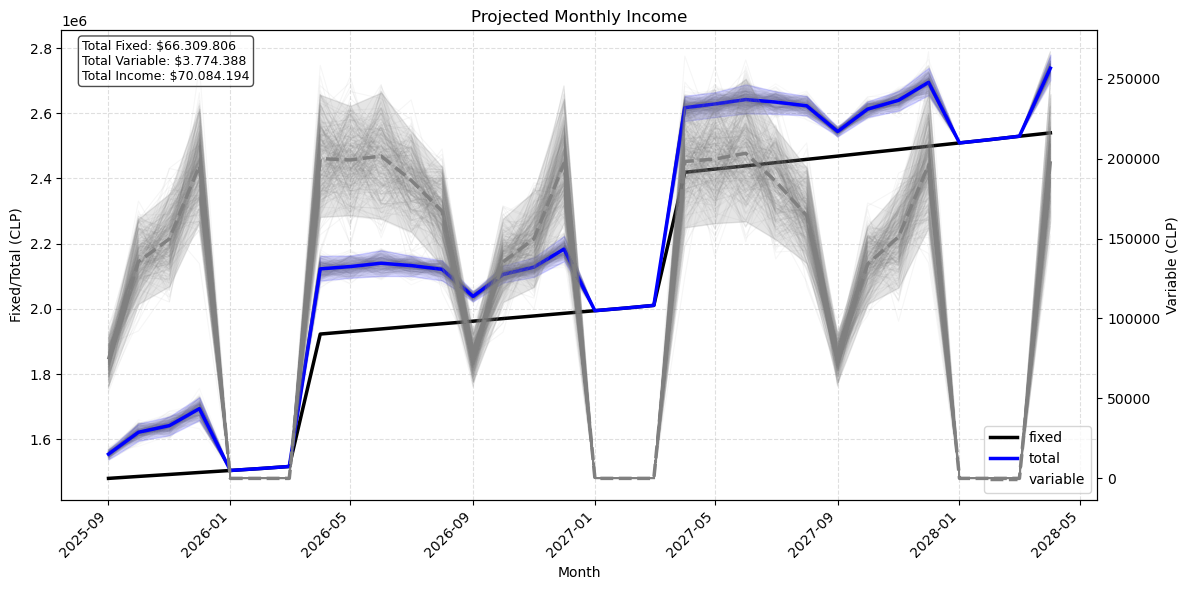

In [7]:
# ==============================
# Income Projection Simulation
# ==============================
from datetime import date

# --- Simulation parameters ---
months = 32
start_date = date(2025, 9, 1)  # Projection start date

# Optional: define custom colors for the plot
plot_colors = {
    "fixed": "black",
    "variable": "gray",
    "total": "blue"
}

# --- Generate and display the projection plot ---
fig, ax = income.plot(
    mode="income",
    months=months,
    start=start_date,
    dual_axis=True,
    title="Projected Monthly Income",
    colors=plot_colors,
    show_trajectories=True,
    trajectory_alpha=0.07,
    show_confidence_band=True,
    n_simulations=300,
    confidence=0.95,
    return_fig_ax=True
)

# Optional: adjust layout for better spacing
fig.tight_layout()

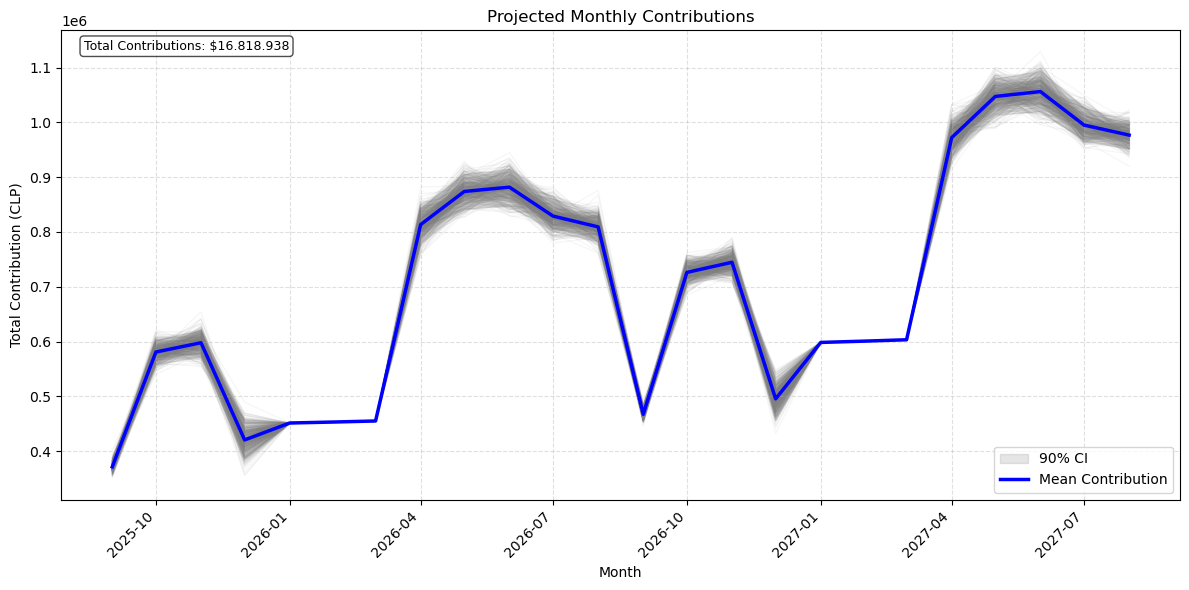

In [18]:
# ==============================
# Contribution Projection Simulation
# ==============================

from datetime import date

# --- Simulation parameters ---
months = 24
start_date = date(2025, 9, 1)  # Projection start date

contrib_colors = {
    "total": "blue",
    "ci": "gray"  # Color de la banda de confianza
}

# --- Generate and display the contributions plot ---
fig, ax = income.plot(
    mode="contributions",
    months=months,
    start=start_date,
    title="Projected Monthly Contributions",
    colors=contrib_colors,
    show_confidence_band=True,
    show_trajectories=True,
    confidence=0.9,
    n_simulations=500,
    return_fig_ax=True
)

# Optional: adjust layout for better spacing
fig.tight_layout()

In [16]:
# Summary for 24 months
summary_24m = income.summary(months=24, start=date(2025, 9, 1))
print("=== Summary (24 months) ===")
print(summary_24m)

=== Summary (24 months) ===
months                                24.00
total_fixed                     46277575.44
total_variable                   3013968.40
total_income                    49291543.84
mean_fixed                       1928232.31
mean_variable                     125582.02
mean_total                       2053814.33
std_variable                       81828.33
coefvar_variable                       0.65
fixed_share                            0.94
variable_share                         0.06
min_variable                           0.00
max_variable                      210449.92
pct_variable_below_threshold            NaN
dtype: float64


# Recursive vs. Closed-Form Wealth Verification

In this experiment, we simulate the monthly wealth evolution of multiple portfolios using an income model composed of fixed and variable cash flows. Wealth is computed in two ways:

1. **Recursive form**:  
   Calculated month by month by adding the monthly contribution and applying the corresponding return:
   $$
   W_{t+1}^m = (W_t^m + A_t^m) \cdot (1 + R_t^m)
   $$

2. **Closed-form (affine) form**:  
   Wealth is obtained directly as a linear-affine function of the contributions and the initial wealth:
   $$
   W_{t+1}^m = W_0^m \prod_{r=0}^{t} (1 + R_r^m) + \sum_{s=0}^{t} A_s^m \prod_{r=s}^{t} (1 + R_r^m)
   $$

The goal is to verify that both formulas coincide in practice, demonstrating that **the recursive version is not necessary** and that optimization problems involving the allocation weights `X` will be **linear-affine** with respect to `X`.

In [51]:
import numpy as np
from datetime import date

from src.income import IncomeModel, FixedIncome, VariableIncome
from src.portfolio import Account, Portfolio
from src.returns import ReturnModel

# -----------------------------
# Parameters
# -----------------------------
months = 24
seed = 42
start_date = date(2025, 6, 1)
M = 3  # number of accounts

# -----------------------------
# Setup income model
# -----------------------------
income = IncomeModel(
    fixed=FixedIncome(base=1_400_000, annual_growth=0.03),
    variable=VariableIncome(base=200_000, sigma=0.10, seed=seed)
)

# Generate contributions
A = income.contributions(months=months, start=start_date, seed=seed, output="array")  # (months,)

# -----------------------------
# Setup portfolio
# -----------------------------
accounts = [
    Account.from_annual(
        name=f"account_{i+1}",
        annual_return=0.07,
        annual_volatility=1e-6,  # near-zero volatility for deterministic test
        initial_wealth=100_000.0
    )
    for i in range(M)
]

portfolio = Portfolio(accounts)
returns_model = ReturnModel(accounts, correlation_matrix=np.eye(M))

# Generate returns
R = returns_model.generate(T=months, n_sims=1, seed=seed)  # (1, months, M)

# Random allocation policy (normalized)
rng = np.random.default_rng(seed)
X = rng.uniform(0, 1, size=(months, M))
X /= X.sum(axis=1, keepdims=True)  # rows sum to 1

# -----------------------------
# Test: Recursive vs Affine
# -----------------------------
result_recursive = portfolio.simulate(A=A, R=R, X=X, method="recursive")
result_affine = portfolio.simulate(A=A, R=R, X=X, method="affine")

W_recursive = result_recursive["wealth"]  # (1, months+1, M)
W_affine = result_affine["wealth"]        # (1, months+1, M)

# Extract single simulation
W_rec = W_recursive[0, :, :]  # (months+1, M)
W_aff = W_affine[0, :, :]     # (months+1, M)

# -----------------------------
# Validation
# -----------------------------
diff = W_rec - W_aff
max_abs_diff = np.abs(diff).max()

print(f"Shape W_recursive: {W_rec.shape}")
print(f"Shape W_affine: {W_aff.shape}")
print(f"Max absolute difference: {max_abs_diff:.2e}")

if np.allclose(W_rec, W_aff, rtol=1e-9, atol=1e-10):
    print("✓ Methods agree within numerical tolerance")
else:
    print("✗ Warning: methods differ beyond tolerance")
    print(f"  Max relative error: {np.abs(diff / (W_rec + 1e-12)).max():.2e}")
    
    # Identify worst mismatch
    worst_idx = np.unravel_index(np.argmax(np.abs(diff)), diff.shape)
    print(f"  Worst mismatch at (t={worst_idx[0]}, account={worst_idx[1]}):")
    print(f"    Recursive: {W_rec[worst_idx]:.6f}")
    print(f"    Affine: {W_aff[worst_idx]:.6f}")

Shape W_recursive: (25, 3)
Shape W_affine: (25, 3)
Max absolute difference: 3.73e-09
✓ Methods agree within numerical tolerance


# Monte Carlo Simulation of Wealth Evolution

This cell simulates the evolution of a single portfolio over 24 months using **Monte Carlo** with `N = 1000` scenarios to study **volatility** and outcome distribution.

### Steps:

1. **Income model**: Combines fixed salary (with growth and raises) and variable income (seasonal, noisy, capped/floored).  
2. **Portfolio**: One account with specified return, volatility, and initial wealth.  
3. **Simulation**: For each scenario, generate monthly contributions and random returns, then compute wealth evolution.  
4. **Analysis**: Compute mean and standard deviation to capture average trajectory and 95% confidence interval.  
5. **Visualization**:  
   - Gray lines: individual Monte Carlo trajectories.  
   - Blue line & shaded band: mean wealth and 95% CI.  
   - Right-side histogram: distribution of final wealth, showing where trajectories converge.  

This approach provides an intuitive view of **risk, dispersion, and expected outcomes** over time.


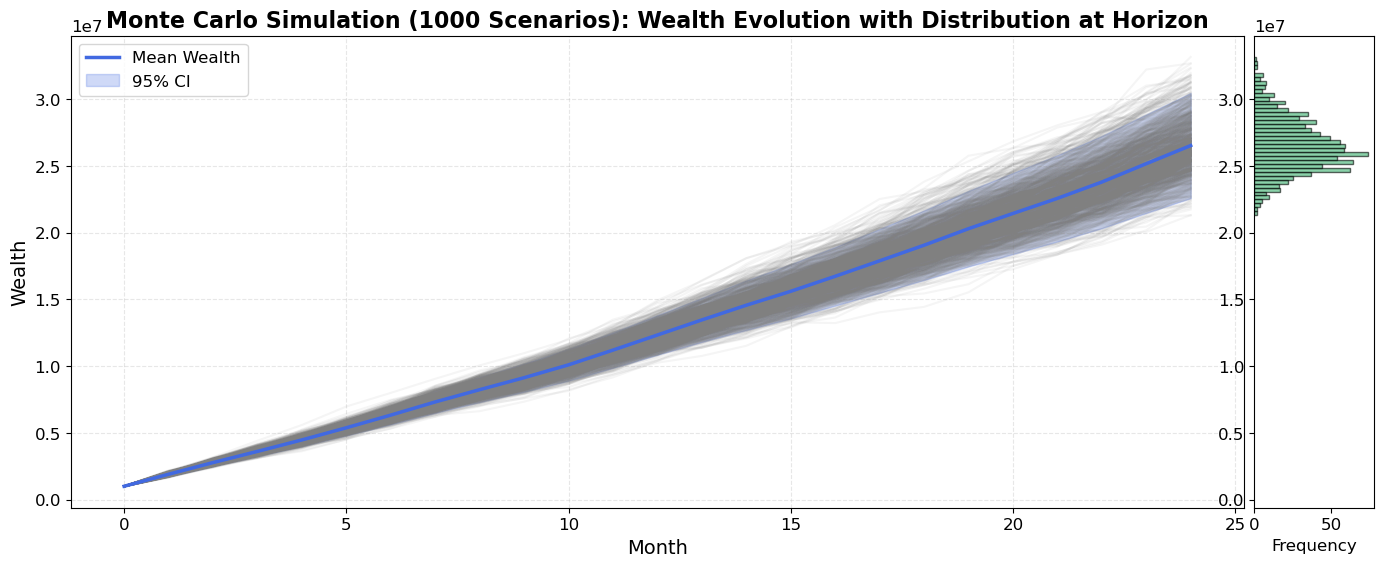

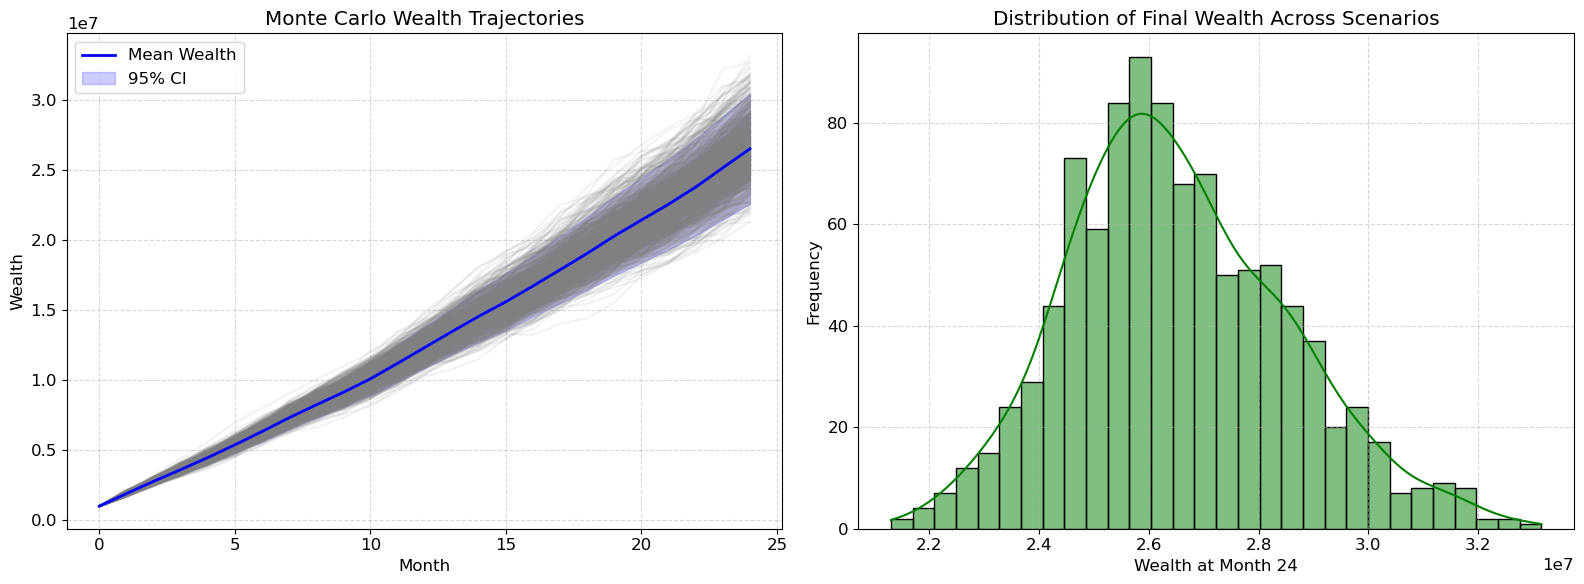

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from datetime import date

from src.income import IncomeModel, FixedIncome, VariableIncome
from src.portfolio import Account, Portfolio
from src.returns import ReturnModel

# -----------------------------
# Parámetros de simulación
# -----------------------------
months = 24
N = 1000
seed = 42
start_date = date(2025, 6, 1)

# -----------------------------
# Configurar income (vectorizado)
# -----------------------------
seasonality_variable = [1.0, 0.95, 1.05, 1.10, 1.15, 1.10, 
                        1.0, 0.90, 0.95, 1.05, 1.10, 1.20]

income = IncomeModel(
    fixed=FixedIncome(
        base=1_480_000.0,
        annual_growth=0.05,
        salary_raises={
            date(2026, 4, 1): 400_000,
            date(2027, 4, 1): 400_000
        }
    ),
    variable=VariableIncome(
        base=400_000.0,
        seasonality=seasonality_variable,
        sigma=0.10,  # 10% noise
        floor=0.0,
        cap=4_000_000.0,
        annual_growth=0.0,
        seed=seed
    )
)

# -----------------------------
# Configurar portfolio y returns (vectorizado)
# -----------------------------
accounts = [
    Account.from_annual(
        name="main",
        annual_return=0.09,        # 9% anual (no 9% mensual)
        annual_volatility=0.08,    # 10% volatilidad anual
        initial_wealth=1_000_000.0
    )
]

portfolio = Portfolio(accounts)
returns = ReturnModel(accounts, correlation_matrix=np.eye(1))

# -----------------------------
# Generar inputs vectorizados (CRÍTICO: una sola llamada)
# -----------------------------
A = income.contributions(months=months, start=start_date, 
                         n_sims=N, seed=seed, output="array")  # (N, T)
R = returns.generate(T=months, n_sims=N, seed=seed)  # (N, T, 1)

# Allocation policy: 100% a única cuenta
X = np.ones((months, 1))

# -----------------------------
# Simular (vectorizado: N escenarios simultáneos)
# -----------------------------
result = portfolio.simulate(A=A, R=R, X=X, method="recursive")
W_total = result["total_wealth"]  # (N, T+1)

# Transponer para match con código legacy: (T+1, N)
wealth_scenarios = W_total.T

# -----------------------------
# Análisis estadístico
# -----------------------------
wealth_mean = wealth_scenarios.mean(axis=1)
wealth_std = wealth_scenarios.std(axis=1)
final_wealth = wealth_scenarios[-1, :]
months_idx = np.arange(0, months + 1)

# ============================================================================
# OPCIÓN 1: Plot compuesto con histograma lateral (legacy style)
# ============================================================================
mpl.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=(14, 6))

# Trayectorias Monte Carlo
for i in range(N):
    ax.plot(months_idx, wealth_scenarios[:, i], color='gray', alpha=0.08)

# Media y CI
ax.plot(months_idx, wealth_mean, color='royalblue', lw=2.5, label='Mean Wealth')
ax.fill_between(
    months_idx,
    wealth_mean - 1.96 * wealth_std,
    wealth_mean + 1.96 * wealth_std,
    color='royalblue', alpha=0.25, label='95% CI'
)

# Estética
ax.set_xlabel("Month", fontsize=14)
ax.set_ylabel("Wealth", fontsize=14)
ax.set_title(f"Monte Carlo Simulation ({N} Scenarios): Wealth Evolution with Distribution at Horizon",
             fontsize=16, fontweight='bold')
ax.grid(True, linestyle='--', alpha=0.3)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(loc='upper left', fontsize=12)

# Histograma lateral
divider = make_axes_locatable(ax)
ax_hist = divider.append_axes("right", size=1.2, pad=0.1)
ax_hist.hist(final_wealth, bins=40, orientation='horizontal',
             color='mediumseagreen', alpha=0.6, edgecolor='black')
ax_hist.set_xlabel("Frequency", fontsize=12)
ax_hist.set_ylim(ax.get_ylim())
ax_hist.tick_params(axis='y', labelsize=12)
ax_hist.grid(False)

plt.tight_layout()
plt.show()

# ============================================================================
# OPCIÓN 2: Dos paneles separados (seaborn style)
# ============================================================================
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Panel 1: Trayectorias
for i in range(N):
    axes[0].plot(months_idx, wealth_scenarios[:, i], color='gray', alpha=0.1)

axes[0].plot(months_idx, wealth_mean, color='blue', lw=2, label='Mean Wealth')
axes[0].fill_between(
    months_idx,
    wealth_mean - 1.96 * wealth_std,
    wealth_mean + 1.96 * wealth_std,
    color='blue', alpha=0.2, label='95% CI'
)
axes[0].set_xlabel("Month")
axes[0].set_ylabel("Wealth")
axes[0].set_title("Monte Carlo Wealth Trajectories")
axes[0].grid(True, linestyle='--', alpha=0.5)
axes[0].legend()

# Panel 2: Distribución final
sns.histplot(final_wealth, bins=30, kde=True, ax=axes[1], color='green')
axes[1].set_xlabel(f"Wealth at Month {months}")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Distribution of Final Wealth Across Scenarios")
axes[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

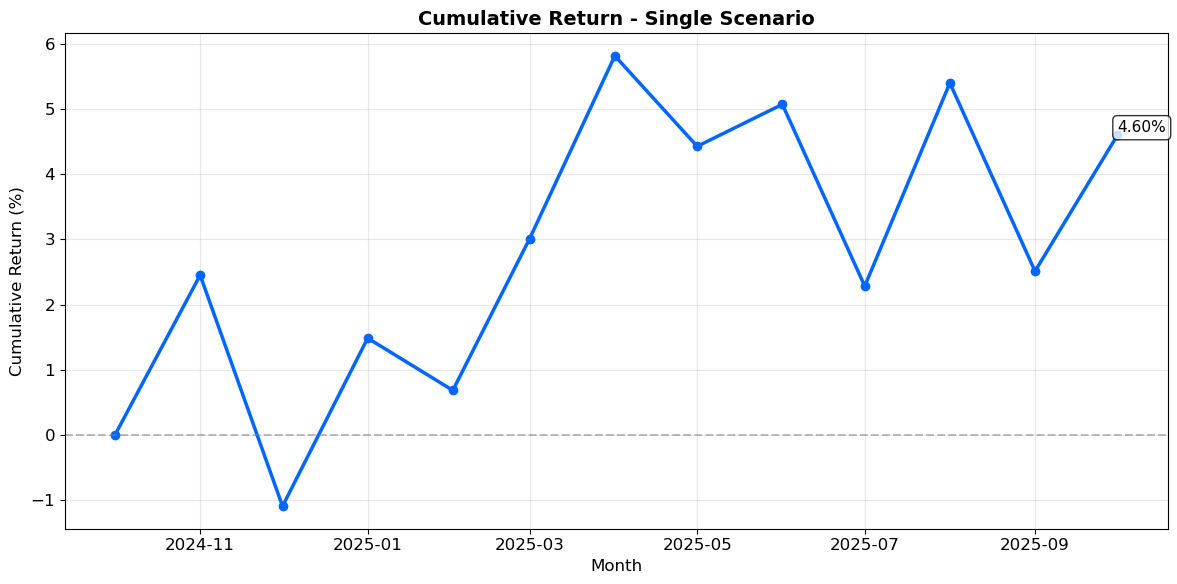

Final return (1 year): 4.60%
Average monthly return: 0.40%


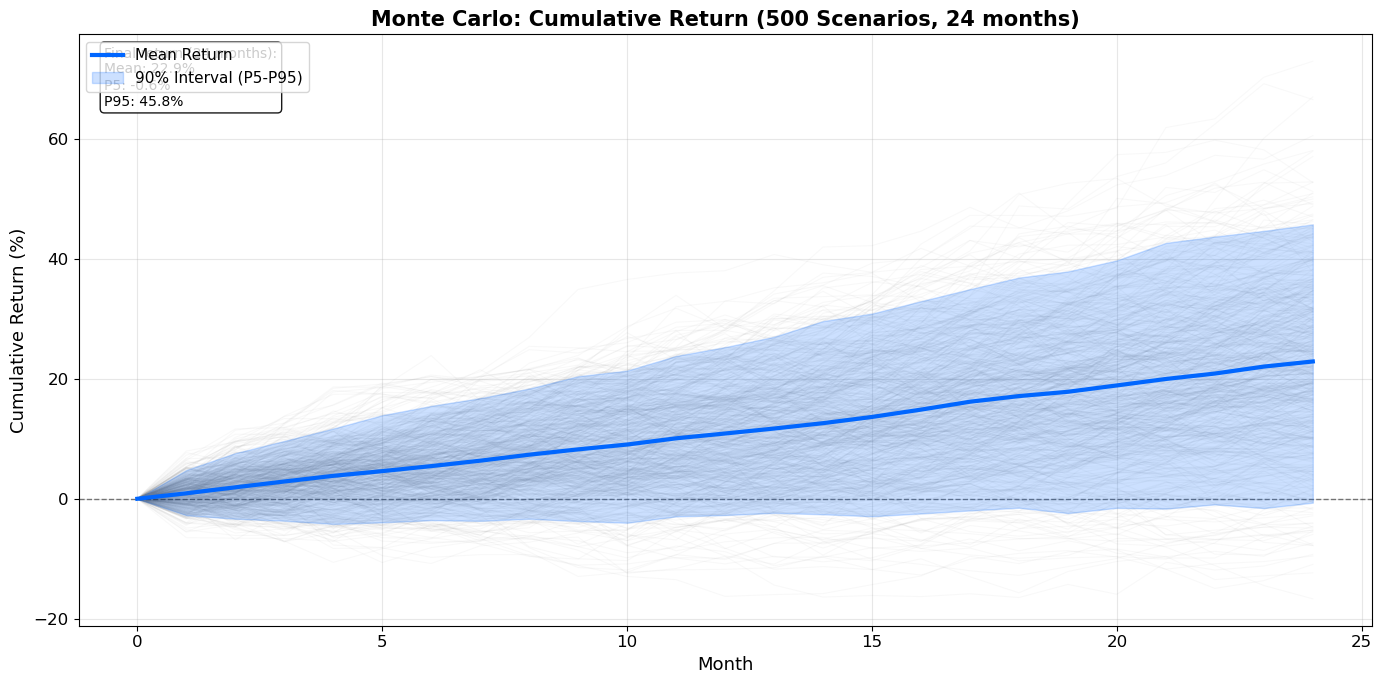


=== Validation ===
Theoretical return (2 years): 21.00%
Average simulated return: 22.90%
Difference: 1.90%


In [44]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
from dateutil.relativedelta import relativedelta

from src.portfolio import Account
from src.returns import ReturnModel

# Calibrated parameters
mu_annual = 0.10
sigma_annual = 0.08

# Create account
moderate_pitt = Account.from_annual(
    "Moderate Pitt",
    annual_return=mu_annual,
    annual_volatility=sigma_annual,
    initial_wealth=0
)

# Generate returns
returns_model = ReturnModel([moderate_pitt], correlation_matrix=np.eye(1))

# ============================================================================
# CASE 1: Single trajectory
# ============================================================================
T = 12  # 1 year
R = returns_model.generate(T=T, n_sims=1)  # (1, 12, 1)
monthly_returns = R[0, :, 0]  # (12,)

# Calculate cumulative return month by month
cumulative_return = np.zeros(T + 1)
cumulative_return[0] = 0.0  # initial return = 0%

for t in range(T):
    # ρ_t = ∏(1 + R_s) - 1
    cumulative_return[t + 1] = np.prod(1 + monthly_returns[:t+1]) - 1

# Convert to percentage
cumulative_return_pct = cumulative_return * 100

# Create time index
start_date = date(2024, 10, 1)
months_idx = [start_date + relativedelta(months=i) for i in range(T + 1)]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(months_idx, cumulative_return_pct, linewidth=2.5, color='#0066FF', marker='o')
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.ylabel('Cumulative Return (%)', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.title('Cumulative Return - Single Scenario', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Annotate final return
final_return = cumulative_return_pct[-1]
plt.text(months_idx[-1], final_return, f'{final_return:.2f}%', 
         fontsize=11, ha='left', va='bottom', bbox=dict(boxstyle='round', 
         facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

print(f"Final return (1 year): {final_return:.2f}%")
print(f"Average monthly return: {monthly_returns.mean()*100:.2f}%")

# ============================================================================
# CASE 2: Monte Carlo (multiple trajectories)
# ============================================================================
n_sims = 500
T = 24  # 2 years for more dispersion

R_mc = returns_model.generate(T=T, n_sims=n_sims)  # (500, 24, 1)

# Calculate cumulative return for each simulation
cumulative_returns = np.zeros((n_sims, T + 1))

for sim in range(n_sims):
    for t in range(T):
        # ρ_t = ∏_{s=0}^{t} (1 + R_s) - 1
        cumulative_returns[sim, t + 1] = np.prod(1 + R_mc[sim, :t+1, 0]) - 1

cumulative_returns_pct = cumulative_returns * 100

# Statistics
mean_return = cumulative_returns_pct.mean(axis=0)
std_return = cumulative_returns_pct.std(axis=0)
p5 = np.percentile(cumulative_returns_pct, 5, axis=0)
p95 = np.percentile(cumulative_returns_pct, 95, axis=0)

# Time index
months_idx_mc = np.arange(T + 1)

# Monte Carlo plot
fig, ax = plt.subplots(figsize=(14, 7))

# Individual trajectories (transparent)
for sim in range(n_sims):
    ax.plot(months_idx_mc, cumulative_returns_pct[sim, :], 
            color='gray', alpha=0.05, linewidth=0.8)

# Mean
ax.plot(months_idx_mc, mean_return, color='#0066FF', linewidth=3, 
        label='Mean Return', zorder=10)

# 90% confidence interval
ax.fill_between(months_idx_mc, p5, p95, color='#0066FF', alpha=0.2, 
                label='90% Interval (P5-P95)', zorder=5)

# Reference line
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1)

# Aesthetics
ax.set_xlabel('Month', fontsize=13)
ax.set_ylabel('Cumulative Return (%)', fontsize=13)
ax.set_title(f'Monte Carlo: Cumulative Return ({n_sims} Scenarios, {T} months)', 
             fontsize=15, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(loc='upper left', fontsize=11)

# Final annotation
final_mean = mean_return[-1]
final_p5 = p5[-1]
final_p95 = p95[-1]
ax.text(0.02, 0.98, 
        f'Final return ({T} months):\n'
        f'Mean: {final_mean:.1f}%\n'
        f'P5: {final_p5:.1f}%\n'
        f'P95: {final_p95:.1f}%',
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

plt.tight_layout()
plt.show()

# Theoretical validation
expected_return_2y = ((1 + mu_annual)**2 - 1) * 100
print(f"\n=== Validation ===")
print(f"Theoretical return (2 years): {expected_return_2y:.2f}%")
print(f"Average simulated return: {final_mean:.2f}%")
print(f"Difference: {abs(expected_return_2y - final_mean):.2f}%")

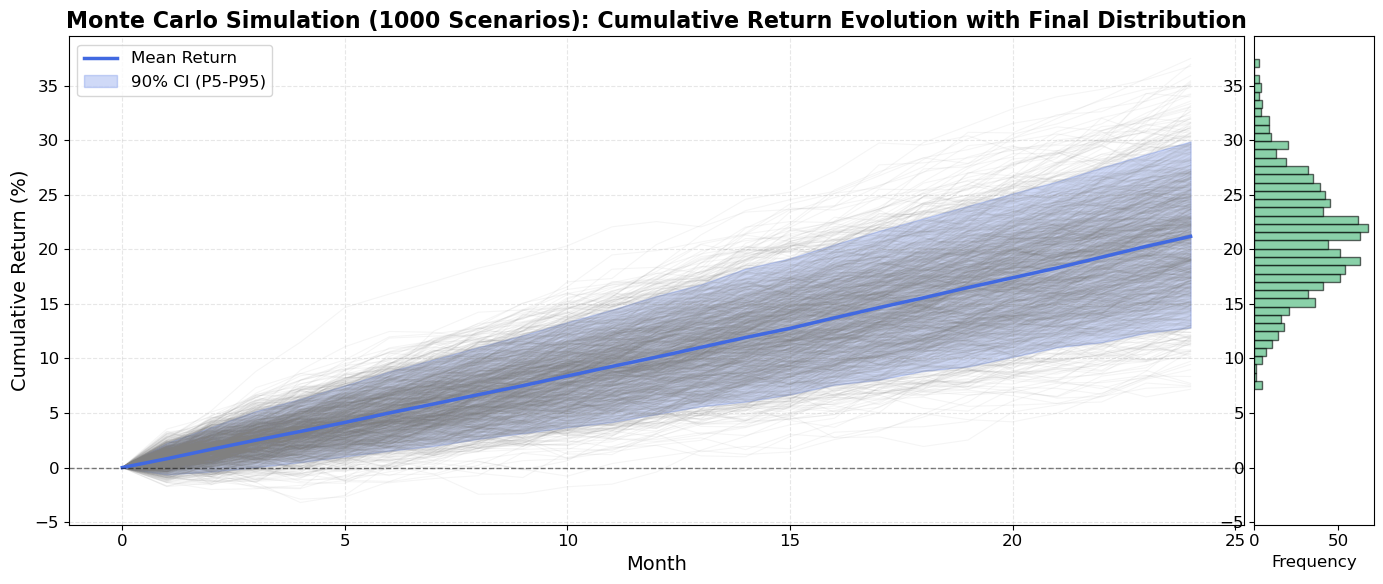

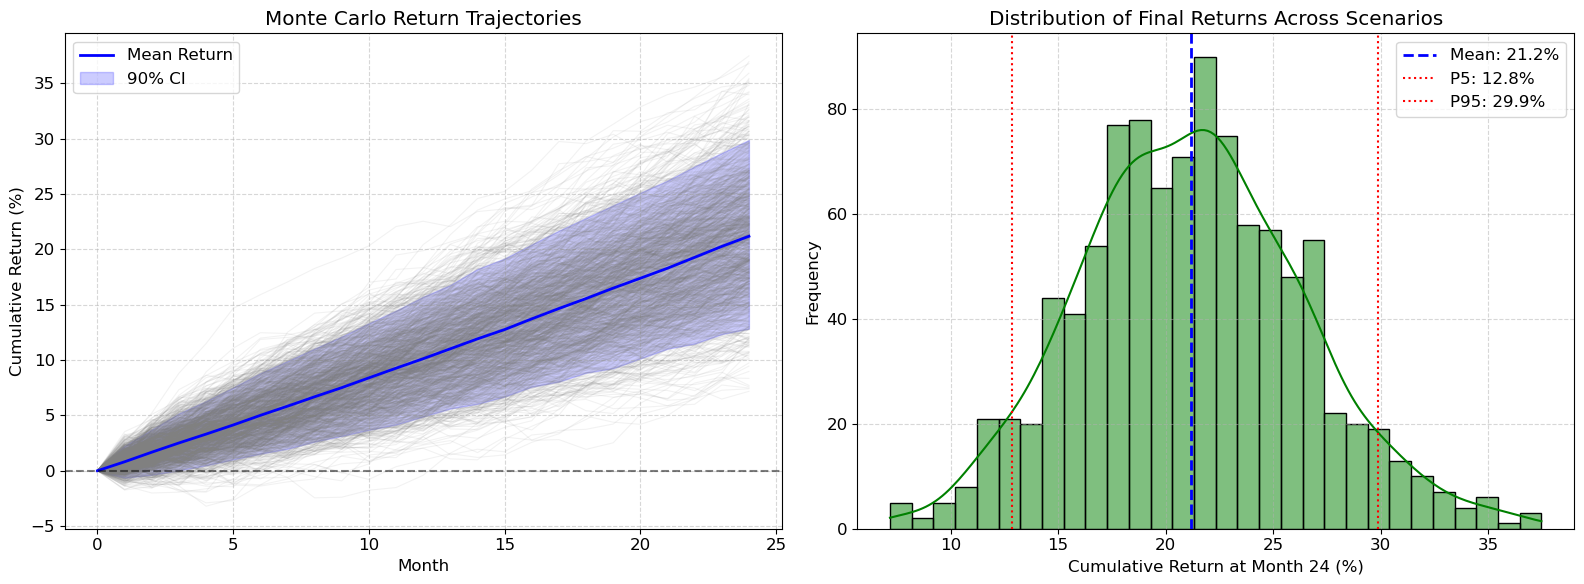


=== Validation ===
Theoretical return (2 years): 21.00%
Mean simulated return: 21.18%
Difference: 0.18%

=== Final Distribution Statistics ===
Mean: 21.18%
Std: 5.17%
P5: 12.84%
P50 (Median): 21.14%
P95: 29.88%
Min: 7.17%
Max: 37.48%


In [45]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from datetime import date
from dateutil.relativedelta import relativedelta

from src.portfolio import Account
from src.returns import ReturnModel

# Calibrated parameters
mu_annual = 0.10
sigma_annual = 0.03

# Create account
moderate_pitt = Account.from_annual(
    "Moderate Pitt",
    annual_return=mu_annual,
    annual_volatility=sigma_annual,
    initial_wealth=0
)

# Generate returns
returns_model = ReturnModel([moderate_pitt], correlation_matrix=np.eye(1))

# Monte Carlo simulation
n_sims = 1000
T = 24  # 2 years

R_mc = returns_model.generate(T=T, n_sims=n_sims, seed=42)  # (1000, 24, 1)

# Calculate cumulative return for each simulation (vectorized)
gross_returns = 1 + R_mc[:, :, 0]  # (1000, 24)
cumulative_gross = np.cumprod(gross_returns, axis=1)  # (1000, 24)

# Add t=0
cumulative_returns = np.zeros((n_sims, T + 1))
cumulative_returns[:, 1:] = cumulative_gross - 1
cumulative_returns_pct = cumulative_returns * 100

# Statistics
mean_return = cumulative_returns_pct.mean(axis=0)
p5 = np.percentile(cumulative_returns_pct, 5, axis=0)
p95 = np.percentile(cumulative_returns_pct, 95, axis=0)
final_returns = cumulative_returns_pct[:, -1]

# Time index
months_idx = np.arange(T + 1)

# ============================================================================
# OPTION 1: Composite plot with side histogram (legacy style)
# ============================================================================
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=(14, 6))

# Monte Carlo trajectories
for sim in range(n_sims):
    ax.plot(months_idx, cumulative_returns_pct[sim, :], 
            color='gray', alpha=0.08, linewidth=0.8)

# Mean and CI
ax.plot(months_idx, mean_return, color='royalblue', linewidth=2.5, label='Mean Return')
ax.fill_between(months_idx, p5, p95, color='royalblue', alpha=0.25, label='90% CI (P5-P95)')

# Reference line
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1)

# Aesthetics
ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel('Cumulative Return (%)', fontsize=14)
ax.set_title(f'Monte Carlo Simulation ({n_sims} Scenarios): Cumulative Return Evolution with Final Distribution',
             fontsize=16, fontweight='bold')
ax.grid(True, linestyle='--', alpha=0.3)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(loc='upper left', fontsize=12)

# Side histogram
divider = make_axes_locatable(ax)
ax_hist = divider.append_axes("right", size=1.2, pad=0.1)
ax_hist.hist(final_returns, bins=40, orientation='horizontal',
             color='mediumseagreen', alpha=0.6, edgecolor='black')
ax_hist.set_xlabel('Frequency', fontsize=12)
ax_hist.set_ylim(ax.get_ylim())
ax_hist.tick_params(axis='y', labelsize=12)
ax_hist.grid(False)

plt.tight_layout()
plt.show()

# ============================================================================
# OPTION 2: Two-panel layout
# ============================================================================
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Panel 1: Trajectories
for sim in range(n_sims):
    axes[0].plot(months_idx, cumulative_returns_pct[sim, :], 
                color='gray', alpha=0.1, linewidth=0.8)

axes[0].plot(months_idx, mean_return, color='blue', linewidth=2, label='Mean Return')
axes[0].fill_between(months_idx, p5, p95, color='blue', alpha=0.2, label='90% CI')
axes[0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Cumulative Return (%)')
axes[0].set_title('Monte Carlo Return Trajectories')
axes[0].grid(True, linestyle='--', alpha=0.5)
axes[0].legend()

# Panel 2: Final distribution
sns.histplot(final_returns, bins=30, kde=True, ax=axes[1], color='green')
axes[1].axvline(x=mean_return[-1], color='blue', linestyle='--', 
                linewidth=2, label=f'Mean: {mean_return[-1]:.1f}%')
axes[1].axvline(x=p5[-1], color='red', linestyle=':', 
                linewidth=1.5, label=f'P5: {p5[-1]:.1f}%')
axes[1].axvline(x=p95[-1], color='red', linestyle=':', 
                linewidth=1.5, label=f'P95: {p95[-1]:.1f}%')
axes[1].set_xlabel(f'Cumulative Return at Month {T} (%)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Final Returns Across Scenarios')
axes[1].grid(True, linestyle='--', alpha=0.5)
axes[1].legend()

plt.tight_layout()
plt.show()

# Theoretical validation
expected_return_2y = ((1 + mu_annual)**2 - 1) * 100
print(f"\n=== Validation ===")
print(f"Theoretical return (2 years): {expected_return_2y:.2f}%")
print(f"Mean simulated return: {mean_return[-1]:.2f}%")
print(f"Difference: {abs(expected_return_2y - mean_return[-1]):.2f}%")

print(f"\n=== Final Distribution Statistics ===")
print(f"Mean: {final_returns.mean():.2f}%")
print(f"Std: {final_returns.std():.2f}%")
print(f"P5: {np.percentile(final_returns, 5):.2f}%")
print(f"P50 (Median): {np.percentile(final_returns, 50):.2f}%")
print(f"P95: {np.percentile(final_returns, 95):.2f}%")
print(f"Min: {final_returns.min():.2f}%")
print(f"Max: {final_returns.max():.2f}%")

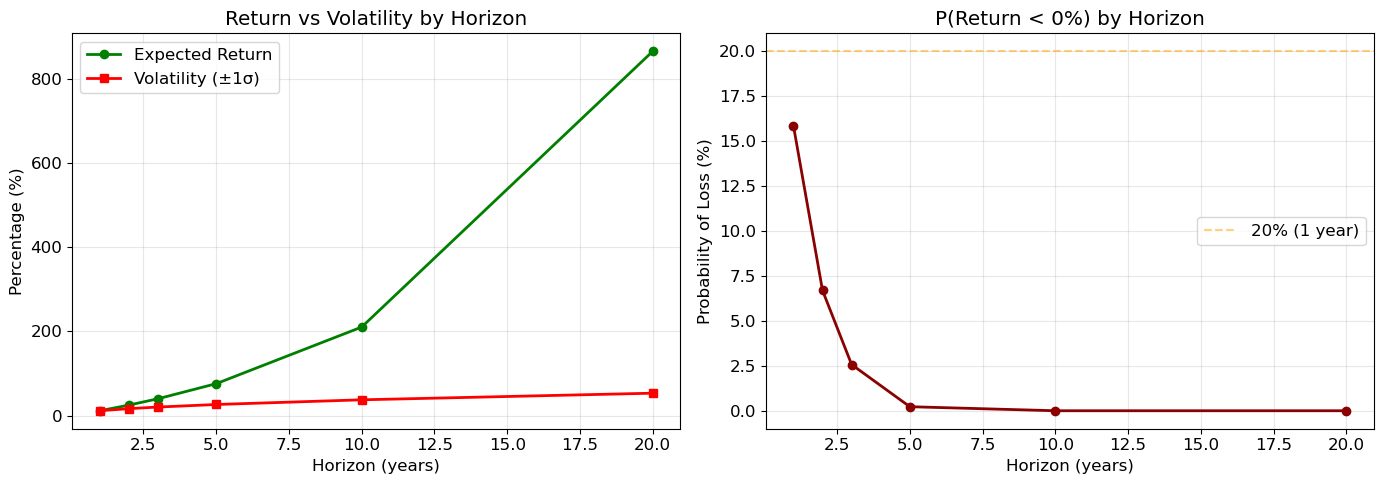


Horizon | Expected | Volatility | P(Loss) | P25-P75 range
--------|----------|------------|---------|---------------
 1 years |   12.0% |   12.0%    |  15.9%  |  16.2%
 2 years |   25.4% |   17.0%    |   6.7%  |  22.9%
 3 years |   40.5% |   20.8%    |   2.6%  |  28.0%
 5 years |   76.2% |   26.8%    |   0.2%  |  36.2%
10 years |  210.6% |   37.9%    |   0.0%  |  51.2%
20 years |  864.6% |   53.7%    |   0.0%  |  72.4%


In [50]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

mu_annual = 0.12
sigma_annual = 0.12

horizons = np.array([1, 2, 3, 5, 10, 20])  # años

# Retorno esperado crece linealmente (compuesto)
expected_return = (1 + mu_annual)**horizons - 1

# Volatilidad crece con √T
volatility = sigma_annual * np.sqrt(horizons)

# Ratio señal/ruido mejora con tiempo
snr = expected_return / volatility

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel 1: Retorno esperado vs volatilidad
axes[0].plot(horizons, expected_return * 100, 'o-', linewidth=2, label='Expected Return', color='green')
axes[0].plot(horizons, volatility * 100, 's-', linewidth=2, label='Volatility (±1σ)', color='red')
axes[0].set_xlabel('Horizon (years)')
axes[0].set_ylabel('Percentage (%)')
axes[0].set_title('Return vs Volatility by Horizon')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Panel 2: Probabilidad de pérdida
prob_loss = stats.norm.cdf(0, expected_return, volatility)
axes[1].plot(horizons, prob_loss * 100, 'o-', linewidth=2, color='darkred')
axes[1].axhline(y=20, color='orange', linestyle='--', alpha=0.5, label='20% (1 year)')
axes[1].set_xlabel('Horizon (years)')
axes[1].set_ylabel('Probability of Loss (%)')
axes[1].set_title('P(Return < 0%) by Horizon')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tabla
print("\nHorizon | Expected | Volatility | P(Loss) | P25-P75 range")
print("--------|----------|------------|---------|---------------")
for T in horizons:
    exp_ret = ((1 + mu_annual)**T - 1) * 100
    vol = sigma_annual * np.sqrt(T) * 100
    p_loss = stats.norm.cdf(0, (1+mu_annual)**T - 1, sigma_annual*np.sqrt(T)) * 100
    p25 = stats.norm.ppf(0.25, (1+mu_annual)**T - 1, sigma_annual*np.sqrt(T)) * 100
    p75 = stats.norm.ppf(0.75, (1+mu_annual)**T - 1, sigma_annual*np.sqrt(T)) * 100
    print(f"{T:2d} years | {exp_ret:6.1f}% | {vol:6.1f}%    | {p_loss:5.1f}%  | {p75-p25:5.1f}%")